# CSIRO Biomass Regression - Modal.com Optimized

**For use with GitHub repository: https://github.com/Triangulr/CSIRO**

This notebook is optimized for running on Modal.com after cloning from GitHub.

**Setup Instructions:**
1. Clone the repository: `git clone https://github.com/Triangulr/CSIRO`
2. Upload/clone the repository to your Modal.com environment
3. Ensure the `dataset/` folder is in the persistent volume at `/mnt/csiro` (or in repository root)
4. Run this notebook

**Recommended Modal Settings:**
- **GPU**: 
  - `a100` (80GB) - **Best value** - Sweet spot for speed/cost
  - `h100` - Faster than A100, still cost-effective
  - `b200` - Fastest available, but likely overkill for EfficientNet-B6
- **CPU**: 8-16 cores
- **RAM**: 64GB
- **Persistent Volume**: Mount at `/mnt/csiro` for dataset storage
- **Batch size**: 
  - A100: 64-128
  - H100: 128-256
  - B200: 128-256 (can go even higher if needed)


## Step 0 · Environment Setup


In [1]:
# Install dependencies (including git if needed)
%pip install -q pytorch-lightning torchmetrics timm pandas numpy matplotlib seaborn pillow tqdm

import os
import random
import subprocess
from pathlib import Path
from typing import Optional, Tuple

# Check if git is available
try:
    subprocess.run(['git', '--version'], capture_output=True, check=True)
    print("✓ Git is available")
except (subprocess.CalledProcessError, FileNotFoundError):
    print("⚠ Git not found - trying to install gitpython...")
    import sys
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'gitpython'], check=False)
    print("⚠ Note: If git clone fails, git may need to be installed as a system package")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T

import timm
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
import torchmetrics
from torchmetrics import MeanAbsoluteError, MeanSquaredError

# Optimize for Tensor Cores (H100, A100, etc.)
if torch.cuda.is_available():
    torch.set_float32_matmul_precision('high')  # Use 'high' for H100, 'medium' for A100
    print("✓ Tensor Core optimization enabled")

print(f"PyTorch: {torch.__version__}")
print(f"PyTorch Lightning: {pl.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
pl.seed_everything(42, workers=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
✓ Git is available
✓ Tensor Core optimization enabled
PyTorch: 2.8.0+cu129
PyTorch Lightning: 2.5.5
CUDA Available: True


Seed set to 42


GPU: NVIDIA H100 80GB HBM3
GPU Memory: 85.0 GB
Using device: cuda


## Step 1 · Clone Repository and Locate Dataset

This step clones the GitHub repository and locates the dataset (either in the persistent volume or in the cloned repo).


In [2]:
# Step 1: Clone repository if not already present
REPO_URL = "https://github.com/Triangulr/CSIRO.git"
REPO_NAME = "CSIRO"
REPO_PATH = Path(REPO_NAME)

if not REPO_PATH.exists():
    print(f"Cloning repository from {REPO_URL}...")
    result = subprocess.run(['git', 'clone', REPO_URL], capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Warning: Git clone failed: {result.stderr}")
        print("Trying to continue anyway...")
    else:
        print(f"✓ Repository cloned successfully to {REPO_PATH.absolute()}")
else:
    print(f"✓ Repository already exists at {REPO_PATH.absolute()}")

# Step 2: Dataset path - prioritize persistent volume on Modal, then repository
# Modal persistent volume is mounted at /mnt/csiro
PERSISTENT_VOLUME_PATH = Path('/mnt/csiro')
MODAL_DATASET_PATH = PERSISTENT_VOLUME_PATH / 'dataset'

# Try paths in order of priority:
# 1. Modal persistent volume (production - if dataset was copied there)
# 2. Cloned repository dataset folder
# 3. Local dataset folder (development/testing)
dataset_paths = [
    MODAL_DATASET_PATH,           # Modal persistent volume
    REPO_PATH / 'dataset',        # Cloned repository
    Path('./dataset'),             # Repository root
    Path('dataset'),                # Current directory
    Path('../dataset'),             # Parent directory
]

PATH_DATA = None
for path in dataset_paths:
    if path.exists() and (path / 'train.csv').exists():
        PATH_DATA = path
        break

if PATH_DATA is None:
    raise FileNotFoundError(
        f"Dataset folder not found! Please ensure 'dataset/' folder exists in one of:\n"
        f"  - Modal persistent volume: {MODAL_DATASET_PATH}\n"
        f"  - Cloned repository: {REPO_PATH / 'dataset'}\n"
        f"  - Repository root: ./dataset\n"
        f"\nCurrent working directory: {os.getcwd()}\n"
        f"Contents: {os.listdir('.')}\n"
        f"Persistent volume exists: {PERSISTENT_VOLUME_PATH.exists()}\n"
        f"Repository path exists: {REPO_PATH.exists()}\n"
        f"\nIf dataset is in the repo, you may need to copy it to the persistent volume:\n"
        f"  mkdir -p {MODAL_DATASET_PATH}\n"
        f"  cp -r {REPO_PATH / 'dataset'}/* {MODAL_DATASET_PATH}/"
    )

print(f"\nUsing data at: {PATH_DATA.absolute()}")
print(f"Repository root: {Path('.').absolute()}")
if PATH_DATA == MODAL_DATASET_PATH:
    print(f"✓ Using Modal persistent volume at {MODAL_DATASET_PATH}")
elif PATH_DATA == REPO_PATH / 'dataset':
    print(f"✓ Using dataset from cloned repository")
    # Optionally copy to persistent volume for future use
    if PERSISTENT_VOLUME_PATH.exists():
        print(f"💡 Tip: Copy dataset to persistent volume for faster access:")
        print(f"   mkdir -p {MODAL_DATASET_PATH} && cp -r {PATH_DATA}/* {MODAL_DATASET_PATH}/")
else:
    print(f"⚠ Using local dataset path (not persistent volume)")

train_csv = PATH_DATA / 'train.csv'
if not train_csv.exists():
    raise FileNotFoundError(f"train.csv not found at {train_csv}")

train_df = pd.read_csv(train_csv)

train_df['Sampling_Date'] = pd.to_datetime(train_df['Sampling_Date'])
train_df['Day_of_Year'] = train_df['Sampling_Date'].dt.dayofyear
train_df['absolute_image_path'] = train_df['image_path'].apply(lambda p: str(PATH_DATA / p))

print(f"\nTrain rows: {len(train_df):,}")
print(f"Targets: {sorted(train_df['target_name'].unique())}")
train_df.head()


Cloning repository from https://github.com/Triangulr/CSIRO.git...
✓ Repository cloned successfully to /root/CSIRO

Using data at: /root/CSIRO/dataset
Repository root: /root
✓ Using dataset from cloned repository
💡 Tip: Copy dataset to persistent volume for faster access:
   mkdir -p /mnt/csiro/dataset && cp -r CSIRO/dataset/* /mnt/csiro/dataset/

Train rows: 1,785
Targets: ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target,Day_of_Year,absolute_image_path
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000,247,CSIRO/dataset/train/ID1011485656.jpg
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984,247,CSIRO/dataset/train/ID1011485656.jpg
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751,247,CSIRO/dataset/train/ID1011485656.jpg
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735,247,CSIRO/dataset/train/ID1011485656.jpg
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750,247,CSIRO/dataset/train/ID1011485656.jpg


## Step 2 · Dataset Class


In [3]:
class BiomassDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        image_root: Path,
        transforms: Optional[torch.nn.Module] = None,
        mode: str = 'train',
        target_column: str = 'target'
    ):
        self.df = df.reset_index(drop=True).copy()
        self.image_root = Path(image_root)
        self.transforms = transforms
        self.mode = mode
        self.target_column = target_column
        self._len = len(self.df) * 2

    def __len__(self) -> int:
        return self._len

    def _load_image(self, image_path: str) -> Image.Image:
        full_path = Path(image_path)
        # If already absolute, use it directly
        if full_path.is_absolute():
            if not full_path.exists():
                raise FileNotFoundError(f"Image not found at absolute path: {full_path}")
        else:
            # If relative, join with image_root
            full_path = self.image_root / image_path
            if not full_path.exists():
                raise FileNotFoundError(
                    f"Image not found at: {full_path}\n"
                    f"  image_path: {image_path}\n"
                    f"  image_root: {self.image_root}\n"
                    f"  image_root exists: {self.image_root.exists()}"
                )
        with Image.open(full_path) as img:
            return img.convert('RGB')

    def __getitem__(self, idx: int):
        row_idx = idx // 2
        crop_side = idx % 2
        row = self.df.iloc[row_idx]
        image = self._load_image(row.get('absolute_image_path', row['image_path']))
        width, height = image.size
        midpoint = width // 2
        if crop_side == 0:
            crop = image.crop((0, 0, midpoint, height))
        else:
            crop = image.crop((midpoint, 0, width, height))
        if self.transforms:
            crop = self.transforms(crop)
        if self.mode == 'test':
            return crop, row['image_path']
        target = torch.tensor(row[self.target_column], dtype=torch.float32)
        return crop, target


## Step 3 · DataModule


In [4]:
class BiomassDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_path: Path,
        batch_size: int = 64,  # Increased for A100 GPU
        img_size: Tuple[int, int] = (528, 528),
        train_split: float = 0.8,
        val_split: float = 0.1,
        test_split: float = 0.1,
        num_workers: Optional[int] = None
    ):
        super().__init__()
        self.data_path = Path(data_path)
        self.batch_size = batch_size
        self.img_size = img_size
        self.train_split = train_split
        self.val_split = val_split
        self.test_split = test_split
        # Use more workers on Modal for faster data loading
        self.num_workers = num_workers or min(os.cpu_count() or 8, 16)

        self.train_transforms = T.Compose([
            T.RandomResizedCrop(self.img_size),
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.ColorJitter(0.1, 0.1, 0.1, 0.1),
            T.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            T.GaussianBlur(3),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.eval_transforms = T.Compose([
            T.CenterCrop(self.img_size),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.train_df = None
        self.val_df = None
        self.test_df = None

    def setup(self, stage: Optional[str] = None) -> None:
        if stage in (None, 'fit', 'test', 'predict'):
            df = pd.read_csv(self.data_path / 'train.csv')
            df['Sampling_Date'] = pd.to_datetime(df['Sampling_Date'])
            df['Day_of_Year'] = df['Sampling_Date'].dt.dayofyear
            
            # Fix path construction - handle cases where image_path might already contain parts of the path
            # Normalize image_path to be relative to self.data_path
            def normalize_image_path(img_path):
                img_path = str(img_path).strip()
                # Remove leading slashes
                img_path = img_path.lstrip('/')
                # If path already contains the dataset folder name, remove it
                if 'dataset/' in img_path:
                    # Find the part after 'dataset/'
                    parts = img_path.split('dataset/')
                    if len(parts) > 1:
                        img_path = parts[-1]
                # If path contains CSIRO/dataset, extract just the part after dataset/
                if 'CSIRO/dataset/' in img_path or 'CSIRO\\dataset\\' in img_path:
                    parts = img_path.replace('\\', '/').split('dataset/')
                    if len(parts) > 1:
                        img_path = parts[-1]
                return img_path
            
            # Normalize image_path first
            df['image_path'] = df['image_path'].apply(normalize_image_path)
            
            # Create absolute paths
            df['absolute_image_path'] = df['image_path'].apply(lambda p: str((self.data_path / p).resolve()))
            
            # Debug: Check a few sample paths
            print(f"\nPath debugging:")
            print(f"  Data path: {self.data_path}")
            print(f"  Sample image_path: {df['image_path'].iloc[0]}")
            print(f"  Sample absolute_image_path: {df['absolute_image_path'].iloc[0]}")
            print(f"  Sample path exists: {Path(df['absolute_image_path'].iloc[0]).exists()}")
            
            df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
            
            # Split into 80/10/10: train/val/test
            total_size = len(df)
            train_size = int(total_size * self.train_split)
            val_size = int(total_size * self.val_split)
            
            self.train_df = df.iloc[:train_size].reset_index(drop=True)
            self.val_df = df.iloc[train_size:train_size + val_size].reset_index(drop=True)
            self.test_df = df.iloc[train_size + val_size:].reset_index(drop=True)
            
            print(f"Dataset splits: Train={len(self.train_df)}, Val={len(self.val_df)}, Test={len(self.test_df)}")

    def train_dataloader(self) -> DataLoader:
        dataset = BiomassDataset(
            df=self.train_df,
            image_root=self.data_path,
            transforms=self.train_transforms,
            mode='train'
        )
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
            persistent_workers=self.num_workers > 0
        )

    def val_dataloader(self) -> DataLoader:
        dataset = BiomassDataset(
            df=self.val_df,
            image_root=self.data_path,
            transforms=self.eval_transforms,
            mode='train'
        )
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True,
            persistent_workers=self.num_workers > 0
        )

    def test_dataloader(self) -> DataLoader:
        dataset = BiomassDataset(
            df=self.test_df,
            image_root=self.data_path,
            transforms=self.eval_transforms,
            mode='train'
        )
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True,
            persistent_workers=self.num_workers > 0
        )


## Step 4 · Model Definition


In [5]:
class BiomassRegressionModel(pl.LightningModule):
    def __init__(
        self,
        model_name: str = 'tf_efficientnet_b6',
        pretrained: bool = True,
        num_targets: int = 1,
        learning_rate: float = 0.0001,
        loss_weight_smooth_l1: float = 0.5
    ):
        super().__init__()
        self.save_hyperparameters()

        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg'
        )
        self.regression_head = nn.Linear(self.backbone.num_features, num_targets)

        self.smooth_l1 = nn.SmoothL1Loss()
        self.mse = nn.MSELoss()
        self.train_mae = MeanAbsoluteError()
        self.train_mse = MeanSquaredError()
        self.val_mae = MeanAbsoluteError()
        self.val_mse = MeanSquaredError()
        self.test_mae = MeanAbsoluteError()
        self.test_mse = MeanSquaredError()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.backbone(x)
        return self.regression_head(features)

    def _compute_loss(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.view_as(targets)
        # Check for NaN/Inf in predictions
        if torch.isnan(preds).any() or torch.isinf(preds).any():
            print(f"Warning: NaN/Inf detected in predictions! NaN count: {torch.isnan(preds).sum()}, Inf count: {torch.isinf(preds).sum()}")
            preds = torch.nan_to_num(preds, nan=0.0, posinf=1e6, neginf=-1e6)
        smooth = self.smooth_l1(preds, targets)
        mse = self.mse(preds, targets)
        weight = self.hparams.loss_weight_smooth_l1
        total = weight * smooth + (1 - weight) * mse
        return total, smooth, mse

    def training_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images).squeeze(-1)
        targets = targets.view_as(preds)
        loss, smooth_loss, mse_loss = self._compute_loss(preds, targets)
        self.train_mae.update(preds, targets)
        self.train_mse.update(preds, targets)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_smooth_l1', smooth_loss, on_step=True, on_epoch=False)
        self.log('train_mse', mse_loss, on_step=True, on_epoch=False)
        self.log('train_mae', self.train_mae, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_mse_epoch', self.train_mse, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images).squeeze(-1)
        targets = targets.view_as(preds)
        loss, smooth_loss, mse_loss = self._compute_loss(preds, targets)
        self.val_mae.update(preds, targets)
        self.val_mse.update(preds, targets)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_smooth_l1', smooth_loss, on_step=False, on_epoch=True)
        self.log('val_mse', mse_loss, on_step=False, on_epoch=True)
        self.log('val_mae', self.val_mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_mse_epoch', self.val_mse, on_step=False, on_epoch=True)
        return {'val_loss': loss}

    def test_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images).squeeze(-1)
        targets = targets.view_as(preds)
        loss, smooth_loss, mse_loss = self._compute_loss(preds, targets)
        self.test_mae.update(preds, targets)
        self.test_mse.update(preds, targets)
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_smooth_l1', smooth_loss, on_step=False, on_epoch=True)
        self.log('test_mse', mse_loss, on_step=False, on_epoch=True)
        self.log('test_mae', self.test_mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_mse_epoch', self.test_mse, on_step=False, on_epoch=True)
        return {'test_loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.learning_rate,
            momentum=0.9
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=3
            # Note: 'verbose' parameter removed in newer PyTorch versions
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }


## Step 5 · Training Configuration


In [6]:
# Initialize data module
data_module = BiomassDataModule(
    data_path=PATH_DATA,
    batch_size=64,  # Increase to 128 if you have A100 80GB or H100
    img_size=(528, 528),
    train_split=0.8,
    val_split=0.1,
    test_split=0.1,
    num_workers=8  # Adjust based on your CPU cores
)
data_module.setup('fit')

# Initialize model
model = BiomassRegressionModel(
    model_name='tf_efficientnet_b6',
    pretrained=True,
    learning_rate=0.0001
)

# Setup logger - save to persistent volume if available, otherwise repository root
if PERSISTENT_VOLUME_PATH.exists():
    log_dir = PERSISTENT_VOLUME_PATH / 'logs'
    log_dir.mkdir(exist_ok=True)
    logger = CSVLogger(save_dir=str(log_dir), name='biomass_regression')
    print(f"✓ Logs will be saved to persistent volume: {log_dir}")
else:
    logger = CSVLogger(save_dir='./logs', name='biomass_regression')
    print(f"⚠ Logs will be saved to repository root: ./logs")

# Configure trainer with optimal settings for Modal
trainer = pl.Trainer(
    max_epochs=20,
    accelerator='gpu',
    devices=1,
    precision='16-mixed',  # Mixed precision for faster training
    log_every_n_steps=10,
    logger=logger,
    gradient_clip_val=1.0,
    enable_progress_bar=True,
    enable_model_summary=True
)

print(f"\nTraining configuration:")
print(f"  Batch size: {data_module.batch_size}")
print(f"  Image size: {data_module.img_size}")
print(f"  Num workers: {data_module.num_workers}")
print(f"  Max epochs: {trainer.max_epochs}")
print(f"  Log directory: {logger.log_dir}")



Path debugging:
  Data path: CSIRO/dataset
  Sample image_path: train/ID1011485656.jpg
  Sample absolute_image_path: /root/CSIRO/dataset/train/ID1011485656.jpg
  Sample path exists: True
Dataset splits: Train=1428, Val=178, Test=179


model.safetensors:   0%|          | 0.00/173M [00:00<?, ?B/s]

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


✓ Logs will be saved to persistent volume: /mnt/csiro/logs

Training configuration:
  Batch size: 64
  Image size: (528, 528)
  Num workers: 8
  Max epochs: 20
  Log directory: /mnt/csiro/logs/biomass_regression/version_3


## Step 6 · Train Model


In [7]:
# Train the model
print("Starting training...")
trainer.fit(model, data_module)

# Test the model
print("\nEvaluating on test set...")
trainer.test(model, data_module)

# Save model to persistent volume if available, otherwise repository root
if PERSISTENT_VOLUME_PATH.exists():
    model_dir = PERSISTENT_VOLUME_PATH / 'models'
    model_dir.mkdir(exist_ok=True)
    model_path = model_dir / 'biomass_regression_model.pth'
    torch.save(model.state_dict(), model_path)
    print(f"\n✓ Model saved to persistent volume: {model_path}")
else:
    model_path = Path('biomass_regression_model.pth')
    torch.save(model.state_dict(), model_path)
    print(f"\n⚠ Model saved to repository root: {model_path}")

print(f"Model size: {Path(model_path).stat().st_size / 1e6:.2f} MB")


Starting training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | backbone        | EfficientNet      | 40.7 M | train
1 | regression_head | Linear            | 2.3 K  | train
2 | smooth_l1       | SmoothL1Loss      | 0      | train
3 | mse             | MSELoss           | 0      | train
4 | train_mae       | MeanAbsoluteError | 0      | train
5 | train_mse       | MeanSquaredError  | 0      | train
6 | val_mae         | MeanAbsoluteError | 0      | train
7 | val_mse         | MeanSquaredError  | 0      | train
8 | test_mae        | MeanAbsoluteError | 0      | train
9 | test_mse        | MeanSquaredError  | 0      | train
--------------------------------


Path debugging:
  Data path: CSIRO/dataset
  Sample image_path: train/ID1011485656.jpg
  Sample absolute_image_path: /root/CSIRO/dataset/train/ID1011485656.jpg
  Sample path exists: True
Dataset splits: Train=1428, Val=178, Test=179


Sanity Checking: |                                                                       | 0/? [00:00<?, ?it/s…

Training: |                                                                              | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating on test set...

Path debugging:
  Data path: CSIRO/dataset
  Sample image_path: train/ID1011485656.jpg
  Sample absolute_image_path: /root/CSIRO/dataset/train/ID1011485656.jpg
  Sample path exists: True
Dataset splits: Train=1428, Val=178, Test=179


Testing: |                                                                               | 0/? [00:00<?, ?it/s…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     562.7092895507812     │
│         test_mae          │    21.547178268432617     │
│         test_mse          │    1104.3616943359375     │
│      test_mse_epoch       │    1104.3616943359375     │
│      test_smooth_l1       │    21.056699752807617     │
└───────────────────────────┴───────────────────────────┘


✓ Model saved to persistent volume: /mnt/csiro/models/biomass_regression_model.pth
Model size: 164.21 MB


## Step 7 · Evaluate and Display Results


In [8]:
# Evaluate on test set and show results
data_module.setup('test')
test_loader = data_module.test_dataloader()

model.eval()
model.to(device)
all_preds, all_targets, all_paths = [], [], []

with torch.no_grad():
    sample_idx = 0
    for images, targets in tqdm(test_loader, desc='Evaluating on test set', total=len(test_loader)):
        images = images.to(device)
        outputs = model(images).squeeze(-1)
        batch_size = len(targets)
        
        for i in range(batch_size):
            row_idx = sample_idx // 2  # Each image produces 2 crops (left/right)
            if row_idx < len(data_module.test_df):
                all_paths.append(data_module.test_df.iloc[row_idx]['image_path'])
                all_preds.append(outputs[i].cpu().item())
                all_targets.append(targets[i].cpu().item())
            sample_idx += 1

# Calculate metrics
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
all_preds = np.clip(all_preds, 0.0, None)

# Average predictions for left/right halves of same image
predictions_raw = pd.DataFrame({
    'image_path': all_paths, 
    'prediction': all_preds,
    'target': all_targets
})
prediction_df = predictions_raw.groupby('image_path', as_index=False).agg({
    'prediction': 'mean',
    'target': 'first'  # Target is same for both halves
})

# Calculate final metrics
test_mae = np.mean(np.abs(prediction_df['prediction'] - prediction_df['target']))
test_mse = np.mean((prediction_df['prediction'] - prediction_df['target'])**2)
test_rmse = np.sqrt(test_mse)

print("\n" + "="*60)
print("MODEL RESULTS ON TEST SET")
print("="*60)
print(f"Test MAE:  {test_mae:.4f}")
print(f"Test MSE:  {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Number of test samples: {len(prediction_df)}")
print("="*60)

# Show sample predictions
print("\nSample predictions vs actual:")
print(prediction_df.head(10).to_string(index=False))



Path debugging:
  Data path: CSIRO/dataset
  Sample image_path: train/ID1011485656.jpg
  Sample absolute_image_path: /root/CSIRO/dataset/train/ID1011485656.jpg
  Sample path exists: True
Dataset splits: Train=1428, Val=178, Test=179


Evaluating on test set:   0%|          | 0/6 [00:01<?, ?it/s]


MODEL RESULTS ON TEST SET
Test MAE:  21.2858
Test MSE:  1022.5521
Test RMSE: 31.9774
Number of test samples: 143

Sample predictions vs actual:
            image_path  prediction    target
train/ID1025234388.jpg    2.135073  6.050000
train/ID1035947949.jpg    3.752469  0.434300
train/ID1049634115.jpg    1.565419 15.083300
train/ID1052620238.jpg    3.071023  0.000000
train/ID1062837331.jpg    2.224969 55.387699
train/ID1098771283.jpg    1.316409  0.452800
train/ID1103883611.jpg    3.288945 12.916600
train/ID1108283583.jpg    3.601376  5.773000
train/ID1121692672.jpg    3.780393  1.395800
 train/ID112966473.jpg    2.696007 30.799999


## Step 8 · Visualize Training Metrics (Optional)


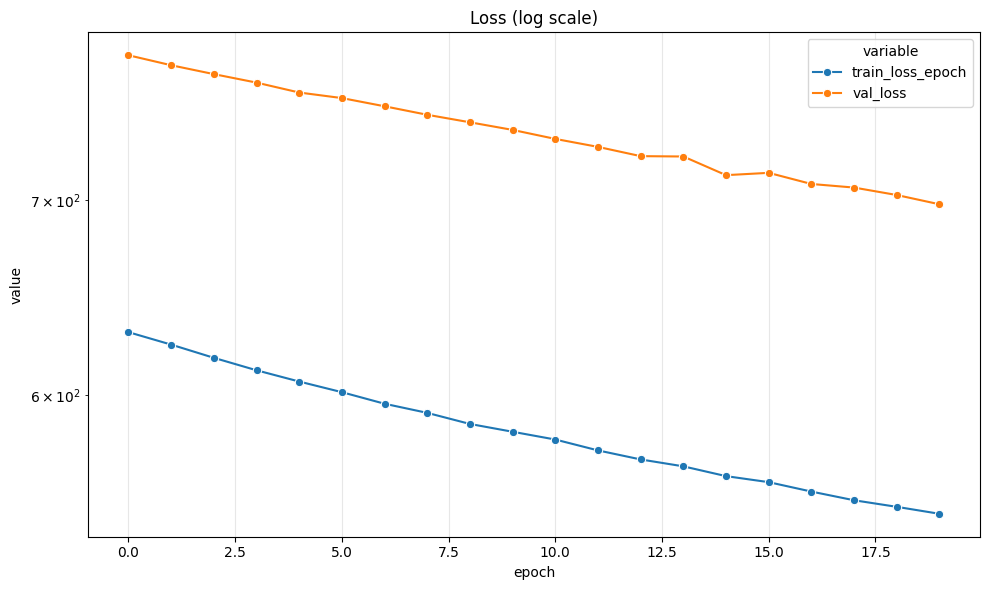

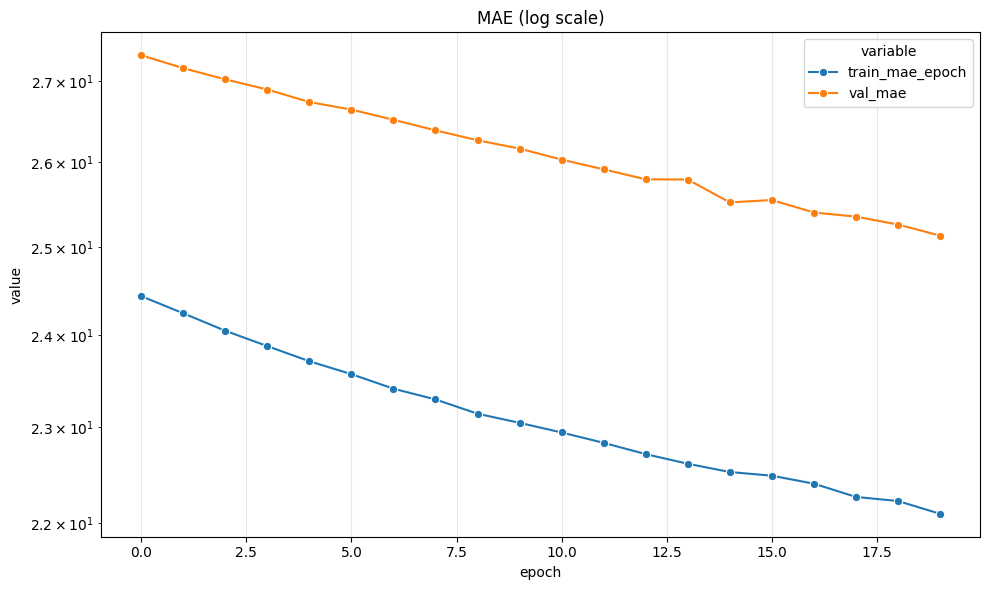

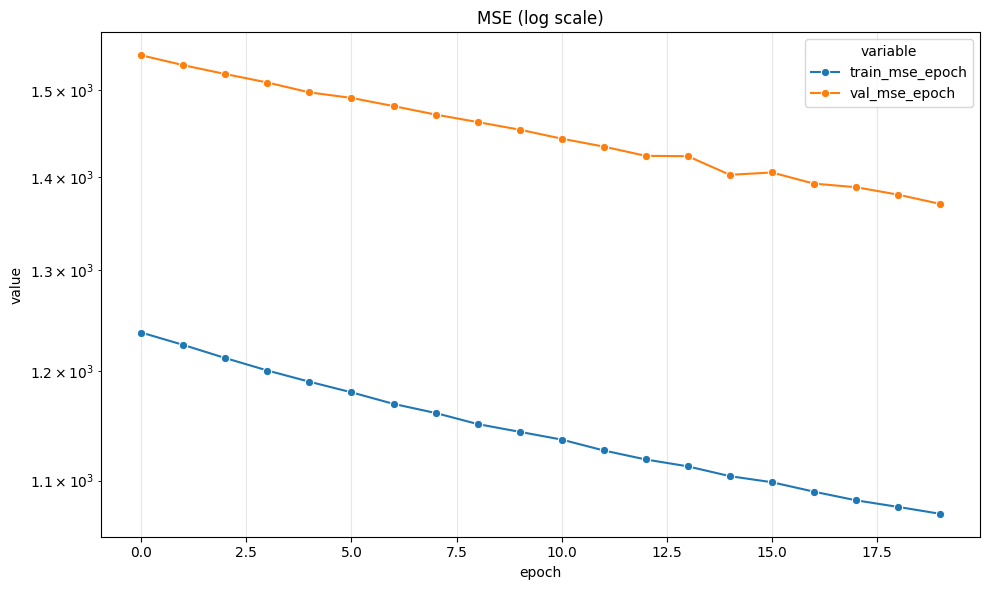

In [9]:
# Plot training metrics
metrics_csv_path = Path(logger.log_dir) / 'metrics.csv'
if metrics_csv_path.exists():
    metrics = pd.read_csv(metrics_csv_path)
    metrics = metrics.drop(columns=[col for col in metrics.columns if col.startswith('step')], errors='ignore')
    
    if 'epoch' not in metrics.columns:
        print(f"Warning: 'epoch' column not found. Available columns: {metrics.columns.tolist()}")
    else:
        metrics = metrics.dropna(subset=['epoch'])
        metrics = metrics.set_index('epoch')
        metrics = metrics.replace([np.inf, -np.inf], np.nan).dropna(how='all', axis=1)
        
        melted = metrics.reset_index().melt(id_vars='epoch')
        
        def plot_metric(subset_keys, title):
            subset = melted[melted['variable'].isin(subset_keys)]
            if subset.empty:
                print(f"No data available for {subset_keys}")
                return
            subset = subset.dropna(subset=['value'])
            if subset.empty:
                print(f"All values are NaN for {subset_keys}")
                return
            plt.figure(figsize=(10, 6))
            sns.lineplot(data=subset, x='epoch', y='value', hue='variable', marker='o')
            plt.yscale('log')
            plt.title(title)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        plot_metric(['train_loss_epoch', 'val_loss'], 'Loss (log scale)')
        plot_metric(['train_mae_epoch', 'val_mae'], 'MAE (log scale)')
        plot_metric(['train_mse_epoch', 'val_mse_epoch'], 'MSE (log scale)')
else:
    print(f"Metrics file not found at {metrics_csv_path}")
